In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

np.set_printoptions(suppress=True, precision=3)

sns.set(style='ticks', palette='Set2')
sns.despine()

In [2]:
import utils as U
import opt_runs as OR
import opt_model as OM
import decorated_options as Deco

# Step 1: Create a SimOpts which will generate raw data

In [3]:
sim_opts_1_follower = OM.SimOpts(
    src_id=0,
    end_time=100,
    s=np.array([1]),
    q=1.0,
    other_sources=[('Hawkes', {'src_id': 1, 'seed': 1, 'l_0': 1.0, 'alpha': 1.0, 'beta': 5.0})],
    sink_ids=[1000],
    edge_list=[(0, 1000), (1, 1000)]
)

# Step 2: Simulate the walls along with different strategies for our broadcaster

### RedQueen

In [84]:
%%time
seed = 1
opt_mgr = sim_opts_1_follower.create_manager_with_opt(seed)
opt_mgr.run_dynamic()
opt_df = opt_mgr.state.get_dataframe()
num_opt_tweets = U.num_tweets_of(opt_df, broadcaster_id=sim_opts_1_follower.src_id)
perf_opt = {
    'type': 'Opt',
    'seed': seed,
    'capacity': num_opt_tweets,
    'q': sim_opts_1_follower.q
}
OR.add_perf(perf_opt, opt_df, sim_opts_1_follower)

CPU times: user 50 ms, sys: 3.33 ms, total: 53.3 ms
Wall time: 55.9 ms


In [85]:
perf_opt

{'avg_rank': 66.8116376874034,
 'capacity': 78.0,
 'num_events': 78,
 'q': 1.0,
 'r_2': 138.15727122691501,
 'seed': 1,
 'top_1': 56.517519051405124,
 'type': 'Opt',
 'world_events': 154}

### Poisson

In [83]:
%%time
seed = 9
poisson_mgr = sim_opts_1_follower.create_manager_with_poisson(seed, capacity=num_opt_tweets)
poisson_mgr.run_dynamic()
poisson_df = poisson_mgr.state.get_dataframe()
num_poisson_tweets = U.num_tweets_of(opt_df, broadcaster_id=sim_opts_1_follower.src_id)
perf_poisson = {
    'type': 'Poisson',
    'seed': seed,
    'capacity': num_poisson_tweets,
    'q': sim_opts_1_follower.q
}
OR.add_perf(perf_poisson, poisson_df, sim_opts_1_follower)

CPU times: user 76.7 ms, sys: 0 ns, total: 76.7 ms
Wall time: 71.8 ms


In [86]:
perf_poisson

{'avg_rank': 201.3461740580856,
 'capacity': 78.0,
 'num_events': 78,
 'q': 1.0,
 'r_2': 1341.2792390212567,
 'seed': 9,
 'top_1': 39.68728199394901,
 'type': 'Poisson',
 'world_events': 154}

# Step 3: Study the performance

In [87]:
print('num_opt_tweets = {}, num_poisson_tweets = {}'
      .format(U.num_tweets_of(opt_df, 0), U.num_tweets_of(poisson_df, 0)))

num_opt_tweets = 78.0, num_poisson_tweets = 78.0


In [79]:
print('avg_rank_opt = {}, avg_rank_poisson = {}'
      .format(U.average_rank(opt_df, sim_opts=sim_opts_1_follower), 
              U.average_rank(poisson_df, sim_opts=sim_opts_1_follower)))

avg_rank_opt = 66.8116376874034, avg_rank_poisson = 201.3461740580856


In [88]:
K = 1
print('Time spent in the top-{} by Redqueen = {} and Poisson = {}'
      .format(K, 
              U.time_in_top_k(opt_df, K=K, sim_opts=sim_opts_1_follower),
              U.time_in_top_k(poisson_df, K=K, sim_opts=sim_opts_1_follower)))

Time spent in the top-1 by Redqueen = 56.517519051405124 and Poisson = 39.68728199394901


### Plot evolution

In [71]:
def plot_feed_evolution(df, src_id):
    # plt.figure(figsize=(8,6))
    
    c1, c2 = sns.color_palette(n_colors=2)

    ranks = U.rank_of_src_in_df(df, src_id).mean(axis=1)
    
    fig, ax1 = plt.subplots()
    
    ax1.fill_between(ranks.index, ranks.values, step='post',
                     color=c1, label=r'$\bar{r}(t)$', alpha=0.5)
    
    ax1.set_ylabel('Rank')
    ax1.set_xlabel('Time')
    ax1.tick_params('y', colors=c1)
    ax1.set_ylim(0)
    
    tweet_times = df[(df.src_id == src_id)].t.unique()
    num_tweets = tweet_times.shape[0]
    
    ax2 = ax1.twinx()
    # plt.vlines(tweet_times[one_month_df] * 60 / 10000, ymin=0, ymax=1200, color=c2, linewidth=0.5)
    ax2.step(tweet_times, np.arange(num_tweets),
             label='$N(t)$', color=c2, linewidth=1.0)
    
    ax2.set_ylabel('Tweets')
    ax2.tick_params('y', colors=c2)
    ax2.set_ylim(0)
    
    plt.tight_layout()
    # plt.legend(loc="upper left")
    # plt.legend(bbox_to_anchor=(0.5, 1.1), bbox_transform=plt.gca().transAxes, ncol=2)
    

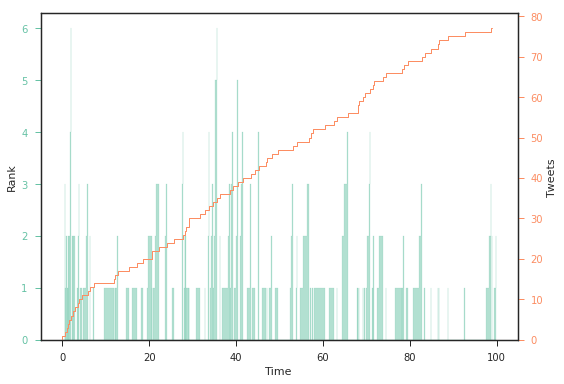

In [72]:
plot_feed_evolution(opt_df, sim_opts_1_follower.src_id)

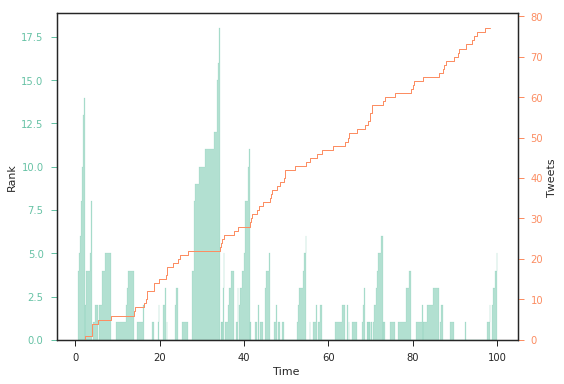

In [73]:
plot_feed_evolution(poisson_df, sim_opts_1_follower.src_id)